In [1]:
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
import numpy as np
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.regularizers import l1, l2

Using TensorFlow backend.


In [2]:
# convert series to supervised learning & normalize input variables
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def data_preparation(df):
    # Get names of indexes for which column temporarily_unable_test has value 1000
    index = df[ df['number_busy'] > 2000 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Get names of indexes for which column temporarily_unable_test has value 1000
    index = df[ df['temporarily_unable_test'] > 1000 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['followup_tests'] = np.log(df['followup_tests'] + 1)
    
    # Get names of indexes for which column outage_hrs has value > 300 
    index = df[ df['quality_too_poor'] > 300 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['outage_hrs'] = np.log(df['outage_hrs'])
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['numbers_tested'] = np.log(df['numbers_tested'])
    
    #df.drop(['followup_tests','outage_hrs', 'numbers_tested'], inplace=True, axis=1)
    
    return df

In [4]:
# load dataset
df = read_csv('../reports/company_report_2.csv', header=0, index_col="time") #2, 9, 49, 93, 130
#df = data_preparation(df)
df = df[['volume_tests', 'date', 'month', 'is_weekend', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'min_commit']]
df = df.dropna(axis='columns')
values = df.values

# specify the number of days and features 
n_input = 7
n_features = df.shape[1]
n_predict = 21

# integer encode direction
#encoder = LabelEncoder()
#values[:,3] = encoder.fit_transform(values[:,3])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_input, n_predict)
print(reframed.shape)

(1181, 308)


In [5]:
# split into train and test sets
values = reframed.values

train_size = int(len(values) * 0.80)
test_size = len(values) - train_size
train, test = values[:train_size,:], values[train_size:,:]

# split into input and outputs
n_obs = n_input * n_features
n_predict_obs = n_predict * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_predict_obs::n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_predict_obs::n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_input, n_features))
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(944, 77) 944 (944, 21)
(944, 7, 11) (944, 21) (237, 7, 11) (237, 21)


Train on 944 samples, validate on 237 samples
Epoch 1/100
944/944 - 3s - loss: 0.2028 - accuracy: 0.0487 - val_loss: 0.2137 - val_accuracy: 0.0633
Epoch 2/100
944/944 - 0s - loss: 0.1670 - accuracy: 0.0964 - val_loss: 0.2100 - val_accuracy: 0.0549
Epoch 3/100
944/944 - 0s - loss: 0.1484 - accuracy: 0.1017 - val_loss: 0.2070 - val_accuracy: 0.0759
Epoch 4/100
944/944 - 0s - loss: 0.1393 - accuracy: 0.0890 - val_loss: 0.2051 - val_accuracy: 0.1097
Epoch 5/100
944/944 - 0s - loss: 0.1344 - accuracy: 0.0858 - val_loss: 0.2034 - val_accuracy: 0.0844
Epoch 6/100
944/944 - 0s - loss: 0.1309 - accuracy: 0.0911 - val_loss: 0.2018 - val_accuracy: 0.0802
Epoch 7/100
944/944 - 0s - loss: 0.1282 - accuracy: 0.0689 - val_loss: 0.1999 - val_accuracy: 0.0759
Epoch 8/100
944/944 - 0s - loss: 0.1261 - accuracy: 0.0816 - val_loss: 0.1980 - val_accuracy: 0.0970
Epoch 9/100
944/944 - 0s - loss: 0.1238 - accuracy: 0.0900 - val_loss: 0.1964 - val_accuracy: 0.1055
Epoch 10/100
944/944 - 0s - loss: 0.1211 - ac

Epoch 81/100
944/944 - 0s - loss: 0.0917 - accuracy: 0.0773 - val_loss: 0.1168 - val_accuracy: 0.0844
Epoch 82/100
944/944 - 0s - loss: 0.0918 - accuracy: 0.0996 - val_loss: 0.1124 - val_accuracy: 0.0886
Epoch 83/100
944/944 - 0s - loss: 0.0914 - accuracy: 0.0869 - val_loss: 0.1128 - val_accuracy: 0.0759
Epoch 84/100
944/944 - 0s - loss: 0.0916 - accuracy: 0.0975 - val_loss: 0.1147 - val_accuracy: 0.0886
Epoch 85/100
944/944 - 0s - loss: 0.0915 - accuracy: 0.0858 - val_loss: 0.1161 - val_accuracy: 0.0549
Epoch 86/100
944/944 - 0s - loss: 0.0917 - accuracy: 0.0847 - val_loss: 0.1117 - val_accuracy: 0.0717
Epoch 87/100
944/944 - 0s - loss: 0.0914 - accuracy: 0.1081 - val_loss: 0.1122 - val_accuracy: 0.1266
Epoch 88/100
944/944 - 0s - loss: 0.0918 - accuracy: 0.0773 - val_loss: 0.1142 - val_accuracy: 0.1181
Epoch 89/100
944/944 - 0s - loss: 0.0911 - accuracy: 0.0858 - val_loss: 0.1136 - val_accuracy: 0.0928
Epoch 90/100
944/944 - 0s - loss: 0.0914 - accuracy: 0.1081 - val_loss: 0.1142 - v

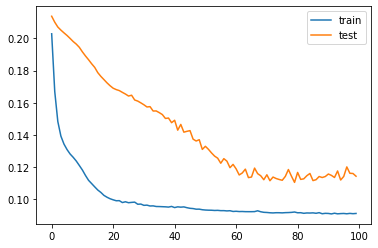

In [6]:
# design LSTM Model
model = Sequential()

model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape=(train_X.shape[1], train_X.shape[2]) ))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(n_predict, kernel_initializer='lecun_uniform', activation='hard_sigmoid'))

optimizer = Adam(lr=0.001, decay=1e-6)
model.compile(loss='mae', optimizer=optimizer, metrics=['accuracy'])

# fit Model
history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot loss history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [7]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_input*n_features))

print(yhat.shape)
print(test_X[:, -(n_features-1):].shape)

pred_arr = np.empty((test_X.shape[0], 1))
actual_arr = np.empty((test_X.shape[0], 1))

for i in range(0, yhat.shape[1]):
    # invert scaling for forecast
    yhat_col = yhat[:, i].reshape(len(yhat[:, i]), 1)    
    inv_yhat = concatenate((yhat_col, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    inv_yhat = inv_yhat.reshape(len(inv_yhat), 1)
    pred_arr = np.append(pred_arr, inv_yhat, axis=1)    
pred_arr = pred_arr[:,1:]

for i in range(0, test_y.shape[1]):
    # invert scaling for actual
    test_y_col = test_y[:, i].reshape(len(test_y[:, i]), 1)
    inv_y = concatenate((test_y_col, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    inv_y = inv_y.reshape(len(inv_y), 1)
    actual_arr = np.append(actual_arr, inv_y, axis=1)
actual_arr = actual_arr[:,1:]      

# calculate RMSE
for i in range(0, actual_arr.shape[1]):
    rmse = sqrt(mean_squared_error(actual_arr[:, i], pred_arr[:, i]))
    print('t+{} RMSE: {:.3f}'.format(i+1, rmse))

(237, 21)
(237, 10)
t+1 RMSE: 3926.366
t+2 RMSE: 5026.609
t+3 RMSE: 5949.517
t+4 RMSE: 7261.479
t+5 RMSE: 5748.925
t+6 RMSE: 6996.760
t+7 RMSE: 6030.167
t+8 RMSE: 6156.652
t+9 RMSE: 7590.220
t+10 RMSE: 7843.937
t+11 RMSE: 6668.068
t+12 RMSE: 7365.112
t+13 RMSE: 6771.096
t+14 RMSE: 6635.056
t+15 RMSE: 6065.485
t+16 RMSE: 7463.114
t+17 RMSE: 7370.448
t+18 RMSE: 6223.831
t+19 RMSE: 5995.046
t+20 RMSE: 7020.574
t+21 RMSE: 6556.027


In [8]:
# Score model
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
loss, accuracy = model.evaluate(test_X, test_y, verbose=0)
print('Test loss:%.2f%%' % (loss * 100))
print('Test accuracy:%.2f%%' % (accuracy * 100))

print(pred_arr.shape)

Test loss:11.44%
Test accuracy:9.28%
(237, 21)


In [9]:
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))

inv_yhat = pred_arr[:, 0].reshape(len(pred_arr), 1)
inv_y = actual_arr[:, 0].reshape(len(actual_arr), 1)

# print predicted vs expected
num_days = test_y.shape[0]
accuracy_scores = []
for i in range(len(inv_y[:num_days])):
    if inv_y[i] > inv_yhat[i]:
        score = inv_yhat[i] / inv_y[i] * 100
        if score > 0:
            accuracy_scores.append(score)
    else:
        score = inv_y[i] / inv_yhat[i] * 100
        if score > 0:
            accuracy_scores.append(score)
    print('Day=%d, Expected=%.2f, Predicted=%.2f, Accuracy=%.2f%%' % (i+1, inv_y[i], inv_yhat[i], score ))
print("%.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))

Day=1, Expected=24966.00, Predicted=22411.26, Accuracy=89.77%
Day=2, Expected=26358.00, Predicted=23826.88, Accuracy=90.40%
Day=3, Expected=52816.00, Predicted=46065.68, Accuracy=87.22%
Day=4, Expected=53616.00, Predicted=47714.24, Accuracy=88.99%
Day=5, Expected=53234.00, Predicted=47583.12, Accuracy=89.38%
Day=6, Expected=52543.00, Predicted=47844.71, Accuracy=91.06%
Day=7, Expected=50885.00, Predicted=44954.39, Accuracy=88.35%
Day=8, Expected=24961.00, Predicted=21488.96, Accuracy=86.09%
Day=9, Expected=26332.00, Predicted=23097.45, Accuracy=87.72%
Day=10, Expected=51884.00, Predicted=44645.14, Accuracy=86.05%
Day=11, Expected=52157.00, Predicted=45939.46, Accuracy=88.08%
Day=12, Expected=51995.00, Predicted=46140.03, Accuracy=88.74%
Day=13, Expected=52428.00, Predicted=46758.31, Accuracy=89.19%
Day=14, Expected=50566.00, Predicted=44358.44, Accuracy=87.72%
Day=15, Expected=25610.00, Predicted=21328.11, Accuracy=83.28%
Day=16, Expected=26822.00, Predicted=22652.23, Accuracy=84.45%
D

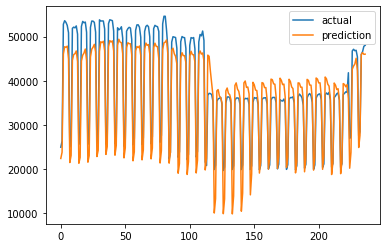

In [10]:
# plot actual vs prediction (All Test Data)
num_days = test_y.shape[0]
pyplot.plot(list(inv_y[:num_days]), label='actual')
pyplot.plot(inv_yhat[:num_days], label='prediction')
pyplot.legend()
pyplot.show()

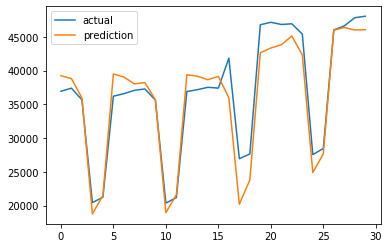

In [11]:
# plot actual vs prediction (Last 30 days)
num_days = 30
pyplot.plot(list(inv_y[-num_days:]), label='actual')
pyplot.plot(inv_yhat[-num_days:], label='prediction')
pyplot.legend()
pyplot.show()

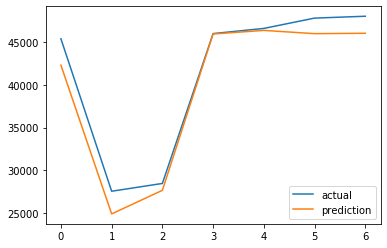

In [12]:
# plot actual vs prediction (Last 7 days)
num_days = 7
pyplot.plot(list(inv_y[-num_days:]), label='actual')
pyplot.plot(inv_yhat[-num_days:], label='prediction')
pyplot.legend()
pyplot.show()

In [13]:

# Predictions Numeric
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
prediction = model.predict(test_X[-1:])
print(prediction.shape)

new_pred_arr = []
for i in range(0, prediction.shape[1]):
    test_X = test_X.reshape((test_X.shape[0], n_input*n_features))
    inv_pred = concatenate(([[prediction[0][i]]], test_X[:prediction.shape[0], -(n_features-1):]), axis=1)
    inv_pred = inv_pred.reshape(1, inv_pred.shape[1])
    inv_pred = scaler.inverse_transform(inv_pred)
    inv_pred = inv_pred[:,0]
    new_pred_arr.append(inv_pred[0])
print(new_pred_arr)

(1, 21)
[46038.76, 47066.566, 34081.215, 36808.496, 47850.91, 50050.082, 50672.26, 47902.945, 50223.645, 35438.91, 34714.73, 51870.305, 49779.89, 50783.43, 47635.17, 50017.61, 35046.227, 34617.785, 48620.69, 51854.465, 52948.223]


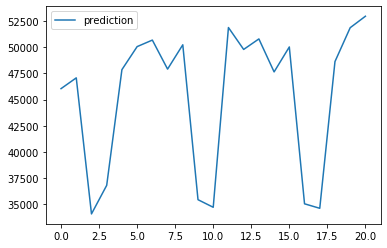

In [14]:
# plot prediction
pyplot.plot(new_pred_arr, label='prediction')
pyplot.legend()
pyplot.show()